In [1]:
import pandas as pd
from pybedtools import BedTool
import numpy as np
from plot_params import *
import matplotlib.pyplot as plt
import seaborn as sns
from plot_params import *
from scipy.stats import fisher_exact, chisquare
from pathlib import Path

In [2]:
def count_functional(fname, to_group = 'feature_type_top'):
    variants = pd.read_csv(fname)
    variants['likely_functional']=((variants['MAF_bin']=='singleton')|
                               (variants['MAF_bin']=='(0.0, 0.0001]') 
                              )&(variants['delta_score']<-0.5)
    functional_bs = variants.groupby(by = 'name')['likely_functional'].any().to_frame()
    functional_bs = functional_bs.merge(variants[['CHROM',
       'name', 'feature_type_top', 'feature_types', 'gene_name',
       'transcript_types', 'transcript_type_top']].drop_duplicates(),
                    left_index = True, right_on = 'name')
    fcount = functional_bs.groupby(by = 'likely_functional')[to_group].value_counts().unstack().fillna(0)
    
    return variants, fcount

In [3]:
def test_for_significance(functional_bs, fcount, to_group = 'feature_type_top', pseudocount = 0):
    rate = functional_bs['likely_functional'].mean()
    rate_vec = pd.Series([rate, 1-rate], index = [True, False])
    rate_vec.name = 'null'
    test_stat = []
    for index, row in pd.pivot_table(functional_bs, index = to_group, 
                                     columns = 'likely_functional', aggfunc = 'size'
                                    ).fillna(0).iterrows():
        cnt = row.sum()
        
        cont = pd.concat([row, cnt*rate_vec], axis = 1)
        # add pseudocount to 0
        cont=(cont.T+rate_vec*pseudocount).T
        
        if row.le(5).any().any():


            _,p = fisher_exact(cont)
        else:
            _,p = chisquare(cont[index], cont['null'])
        test_stat.append([index, p])
    test_stat = pd.DataFrame(test_stat, columns = [to_group, 'pvalue']).set_index(to_group)
    test_stat['odds_ratio']=((fcount.loc[True]/fcount.loc[False])/rate)
    return test_stat

In [4]:
from statsmodels.stats.multitest import fdrcorrection

indir = Path('/tscc/nfs/home/hsher/scratch/variant_score')
to_group = 'feature_type_top'
all_stats = []
data = {}
for f in indir.glob('*.variant_score.csv'):
    df, count = count_functional(f, to_group = to_group)
    data[f.name.split('.')[0]]=df
    stat = test_for_significance(df, count, to_group = to_group)
    stat = pd.concat([stat,count.T], axis = 1)
    stat['RBP']=f.name.split('.')[0]
    all_stats.append(stat.reset_index())
all_stats = pd.concat(all_stats,axis = 0)
_, all_stats['FDR'] = fdrcorrection(all_stats['pvalue'])
all_odds = pd.pivot_table(all_stats, index = 'RBP', columns = 'feature_type_top', values = 'odds_ratio')
all_pv = pd.pivot_table(all_stats, index = 'RBP', columns = 'feature_type_top', values = 'FDR').fillna(1)

In [12]:
all_stats

,feature_type_top,pvalue,odds_ratio,False,True,RBP,FDR
0,CDS,2.248735e-04,4.020931,712.0,7.0,DDX3,7.204281e-04
1,CDS_SOLITARY,1.000000e+00,0.000000,3.0,0.0,DDX3,1.000000e+00
2,CDS_START,1.357198e-04,5.405104,681.0,9.0,DDX3,4.515293e-04
3,CDS_STOP,1.247447e-01,0.000000,83.0,0.0,DDX3,2.766773e-01
4,EXON_LNCRNA,1.000000e+00,23.041475,71.0,4.0,DDX3,1.000000e+00
...,...,...,...,...,...,...,...
12,SS5_PROX,6.052538e-02,0.000000,6.0,0.0,PUM2,1.497909e-01
13,SSB_ADJ,4.925373e-01,0.000000,2.0,0.0,PUM2,8.395871e-01
14,SSB_PROX,1.000000e+00,0.000000,1.0,0.0,PUM2,1.000000e+00
15,UTR3,3.325441e-20,15.789114,229.0,109.0,PUM2,3.595634e-19


In [13]:
all_stats

functional = ['DDX3:UTR5', 'EIF3G:CDS_START', 'FAM120A:UTR3', 'IGF2BP2:UTR3',
              'PRPF8:SS5_ADJ', 'SF3B4:SS3_ADJ', 'PUM2:UTR3', 'RBFOX2:SS3_ADJ',
              'RBFOX2:SS3_PROX', 'RBFOX2:INTRON','RBFOX2:SS5_ADJ',
              'RBFOX2:SS5_PROX', 'RBFOX2:SSB_ADJ',
              'RBFOX2:SSB_PROX', 'RBFOX2:UTR3',
             ]
all_stats['known function']=(all_stats['RBP']+':'+all_stats['feature_type_top']).isin(functional)

In [15]:
all_stats['known function'].value_counts()

False    158
True      15
Name: known function, dtype: int64

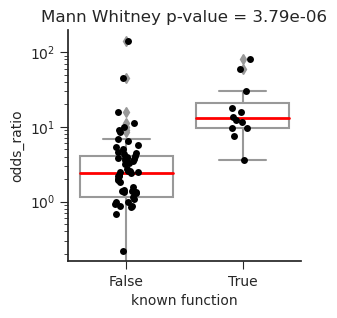

In [40]:
f, ax = plt.subplots(figsize = (3,3))
sns.stripplot(all_stats.loc[all_stats['FDR']<0.2], x = 'known function', y = 'odds_ratio',
             ax = ax, color = 'black')
sns.boxplot(all_stats.loc[all_stats['FDR']<0.2], x = 'known function', y = 'odds_ratio',
             ax = ax, color = 'white',medianprops={"color": "r", "linewidth": 2})
from scipy.stats import mannwhitneyu
_, pv = mannwhitneyu(all_stats.loc[(all_stats['FDR']<0.2)&(all_stats['known function']), 'odds_ratio'],
             all_stats.loc[(all_stats['FDR']<0.2)&(~all_stats['known function']), 'odds_ratio']
            )

plt.title(f'Mann Whitney p-value = {pv:.2e}')
plt.yscale('log')
sns.despine()
plt.savefig(figdir/'functional_var.pdf')

In [41]:
all_stats.loc[(all_stats['FDR']<0.2)&(~all_stats['known function'])].sort_values(by = 'odds_ratio')

,feature_type_top,pvalue,odds_ratio,False,True,RBP,FDR,known function
0,CDS,8.983472e-11,0.000000,67.0,0.0,PUM2,5.550503e-10,False
1,CDS_START,2.522376e-08,0.000000,55.0,0.0,SF3B4,1.212142e-07,False
2,CDS_STOP,5.536786e-05,0.000000,31.0,0.0,SF3B4,1.915728e-04,False
17,UTR5,6.062508e-05,0.000000,300.0,0.0,LIN28B,2.056498e-04,False
6,EXON_SMALL,6.060902e-02,0.000000,11.0,0.0,SF3B4,1.497909e-01,False
...,...,...,...,...,...,...,...,...
3,EXON_LNCRNA,8.978362e-03,9.828630,54.0,16.0,PUM2,2.426963e-02,False
3,CDS_STOP,4.295776e-04,11.329045,329.0,7.0,LIN28B,1.327088e-03,False
7,INTRON,1.539688e-18,15.728454,172.0,1.0,EIF3G,1.566859e-17,False
8,INTRON,1.956630e-127,45.432177,293.0,25.0,LIN28B,1.128323e-125,False


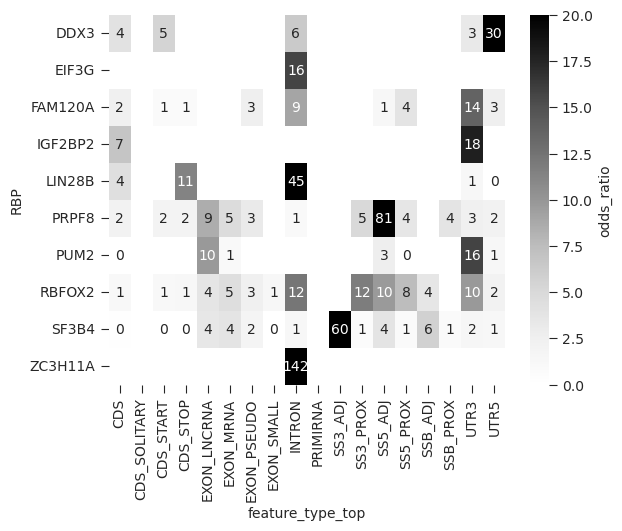

In [5]:
sns.heatmap(all_odds.fillna(0), cmap = 'Greys', mask = all_pv.ge(0.2), 
            vmax = 20, cbar_kws = {'label':'odds_ratio'}, annot = True, 
            fmt = '.0f'
            )
plt.savefig(figdir / 'constrain_feature_type_top.pdf')

In [6]:
to_group = 'transcript_type_top'
all_stats = []
data = {}
for f in indir.glob('*.variant_score.csv'):
    df, count = count_functional(f, to_group = to_group)
    data[f.name.split('.')[0]]=df
    stat = test_for_significance(df, count, to_group = to_group)
    stat = pd.concat([stat,count.T], axis = 1)
    stat['RBP']=f.name.split('.')[0]
    all_stats.append(stat.reset_index())
all_stats = pd.concat(all_stats,axis = 0)
_, all_stats['FDR'] = fdrcorrection(all_stats['pvalue'])
all_odds = pd.pivot_table(all_stats, index = 'RBP', columns = to_group, values = 'odds_ratio')
all_pv = pd.pivot_table(all_stats, index = 'RBP', columns = to_group, values = 'FDR').fillna(1)

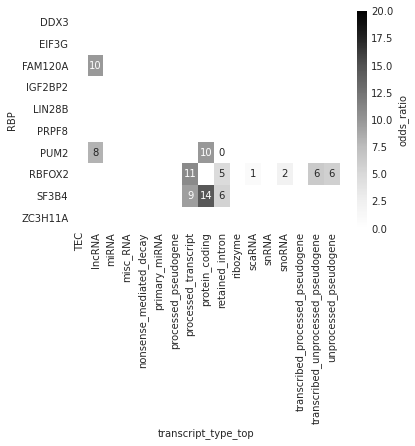

In [7]:
sns.heatmap(all_odds.fillna(0), cmap = 'Greys', mask = all_pv.ge(0.2), 
            vmax = 20, cbar_kws = {'label':'odds_ratio'}, annot = True, 
            fmt = '.0f'
            )
plt.savefig(figdir / 'constrain_transcript_type_top.pdf')

In [8]:
data['RBFOX2'].loc[(data['RBFOX2']['transcript_type_top']=='snoRNA')&
                   (data['RBFOX2']['likely_functional']),
                   'gene_name'
                  ]

105653                     SNORD3A
105662                     SNORD3A
105683                     SNORD3A
148106    EIF1AX:ENSG10010138924.1
Name: gene_name, dtype: object

In [9]:
data['FAM120A'].loc[(data['FAM120A']['transcript_type_top']=='lncRNA')&
                   (data['FAM120A']['likely_functional']),
                   ['gene_name', 'feature_type_top']
                  ]

,gene_name,feature_type_top
50887,RP11-767N6.7,SS3_PROX
50889,RP11-767N6.7,SS3_PROX
81446,RP11-95D17.1,EXON_LNCRNA
97749,AC018890.6,INTRON
116260,B3GALT1-AS1,INTRON
...,...,...
566789,NORAD,EXON_LNCRNA
566811,NORAD,EXON_LNCRNA
567069,NORAD,EXON_LNCRNA
581826,CH17-264L24.2:LL22NC03-80A10.6,SS3_PROX


In [10]:
data['FAM120A'].loc[(data['FAM120A']['feature_type_top']=='UTR3')&
                   (data['FAM120A']['likely_functional']),
                   ['gene_name', 'feature_type_top']
                  ]

,gene_name,feature_type_top
718,VAMP3,UTR3
798,VAMP3,UTR3
801,VAMP3,UTR3
977,PER3,UTR3
1157,UBE4B,UTR3
...,...,...
604774,RBMX,UTR3
604863,FGF13,UTR3
604951,ATP11C,UTR3
604962,ATP11C,UTR3
